In [1]:
import os, sys
sys.path.append("C:/Users/piyalong/CrowdCounting-P2PNet/")

import argparse
import datetime
import random
import time
from pathlib import Path

import torch
import torchvision.transforms as standard_transforms
import numpy as np

from PIL import Image
import cv2
from crowd_datasets import build_dataset
from engine import *
from models import build_model

import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt
%matplotlib inline
torch.cuda.empty_cache() 
import json
from matplotlib.patches import Circle


7


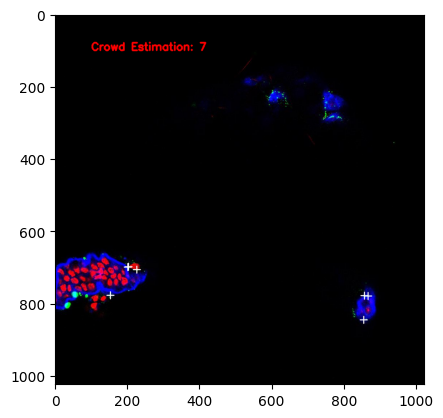

In [2]:
class Args():
    backbone='vgg16_bn'
    gpu_id=0
    img_path='C:/Users/piyalong/Pictures/WT-1_ID_PIC-1_JOA19_5.jpg'
    line=2
    output_dir='output'
    row=2
    weight_path='C:/Users/piyalong/CrowdCounting-P2PNet/ckpt/best_mae.pth'

args=Args()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch. set_grad_enabled(False)
# def main(args, debug=False):

#     os.environ["CUDA_VISIBLE_DEVICES"] = '{}'.format(args.gpu_id)

print(args)
# device = torch.device('cpu')
# get the P2PNet
model = build_model(args)
# move to GPU
model.to(device)
# load trained model
if args.weight_path is not None:
    checkpoint = torch.load(args.weight_path, map_location=device)
    model.load_state_dict(checkpoint['model'])
# convert to eval mode
model.eval()
# create the pre-processing transform
transform = standard_transforms.Compose([
    standard_transforms.ToTensor(), 
    standard_transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# set your image path here
img_path = args.img_path
# load the images
img_raw = Image.open(img_path).convert('RGB')
# round the size
# width, height = img_raw.size
# new_width = width // 128 * 128
# new_height = height // 128 * 128
# img_raw = img_raw.resize((new_width, new_height), Image.ANTIALIAS)
# pre-proccessing
img = transform(img_raw)

samples = torch.Tensor(img).unsqueeze(0)
samples = samples.to(device)
# run inference
outputs = model(samples)
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

outputs_points = outputs['pred_points'][0]

threshold = 0.5
# filter the predictions
points = outputs_points[outputs_scores > threshold].detach().cpu().numpy().tolist()
predict_cnt = int((outputs_scores > threshold).sum())
scores= outputs_scores[outputs_scores > threshold]
outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]

outputs_points = outputs['pred_points'][0]
# draw the predictions
size = 4
img_to_draw = cv2.cvtColor(np.array(img_raw), cv2.COLOR_RGB2BGR)

img_to_draw = cv2.putText(img_to_draw,"Crowd Estimation: "+str(len(points)), (100,100), cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 3)
print(len(points))
for p in points:
    # img_to_draw = cv2.circle(img_to_draw, (int(p[0]), int(p[1])), size, (0, 0, 255), -1)
    cv2.drawMarker(img_to_draw, (int(p[0]), int(p[1])), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)
    
# cv2.rectangle(img_to_draw, (100, 100), (120, 140), (255,255,255), 2)
# save the visualized image
# cv2.imshow('ImageWindow',img_to_draw)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

cv2.imwrite(os.path.join(args.output_dir, 'pred{}.jpg'.format(predict_cnt)), img_to_draw)

img_to_draw = cv2.cvtColor(img_to_draw, cv2.COLOR_BGR2RGB)

fig, ax = plt.subplots()

plt.imshow(img_to_draw)

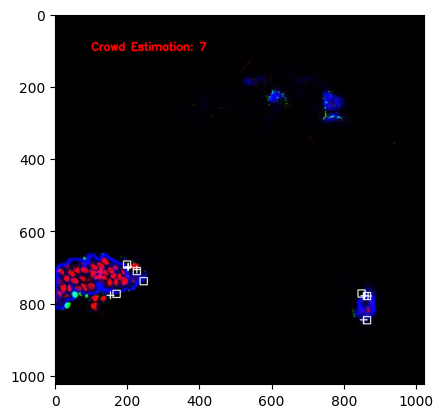

In [3]:

annotations_path = 'D:/via_project_30Mar2023_9h53m_json.json'
# visualize_point_annotations(image_path, annotations_path)


with open(annotations_path, 'r') as f:
    annotations = json.load(f)

# Create a matplotlib figure and axis
fig, ax = plt.subplots(1)

# Display the image
# ax.imshow(image)
ground_truth_pixel_points=[]
# Iterate over annotations and add them to the plot
for annotation in annotations[list(annotations.keys())[0]]['regions']:
    # annotation = annotations[key]

    # Skip if the annotation is not a point
    if annotation["shape_attributes"]["name"] != "point":
        continue

    # Get coordinates
    x = annotation["shape_attributes"]["cx"]
    y = annotation["shape_attributes"]["cy"]
    ground_truth_pixel_points.append([int(x), int(y)])
    # Add the point to the plot
    # circle = Circle((x, y), radius=5, edgecolor='b', facecolor='b')
    cv2.drawMarker(img_to_draw, (int(x), int(y)), (255, 255, 255), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
    # ax.add_patch(circle)

# Show the plot
plt.imshow(img_to_draw)


In [4]:
from scipy.optimize import linear_sum_assignment
import numpy as np
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

# Example pixel point coordinates
predicted_points=np.array(points).astype(int)

gt_points = np.array(ground_truth_pixel_points)

# print(ground_truth_pixel_points.shape,predicted_pixel_points.shape)


6 7 7


Text(0.5, 1.0, 'Recall: 85.71% Precision: 85.71%')

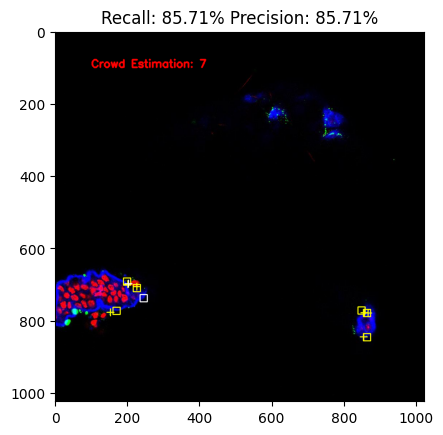

In [5]:
def create_cost_matrix(predicted_points, gt_points, dummy_cost):
    n_points_pred = len(predicted_points)
    n_points_gt = len(gt_points)

    if n_points_pred >= n_points_gt:
        n_rows = n_points_pred
        n_cols = n_points_pred
        n_dummy_points = n_points_pred - n_points_gt
    else:
        n_rows = n_points_gt
        n_cols = n_points_gt
        n_dummy_points = n_points_gt - n_points_pred

    cost_matrix = np.zeros((n_rows, n_cols))

    for i, pred_point in enumerate(predicted_points):
        for j, gt_point in enumerate(gt_points):
            cost_matrix[i, j] = euclidean_distance(pred_point, gt_point)

    for i in range(n_points_pred, n_rows):
        for j in range(n_points_gt, n_cols):
            cost_matrix[i, j] = dummy_cost

    return cost_matrix
dummy_cost=1e6
# def match_points(predicted_points, gt_points, dummy_cost=1e6):
cost_matrix = create_cost_matrix(predicted_points, gt_points, dummy_cost)
row_indices, col_indices = linear_sum_assignment(cost_matrix)
# image_path = 'C:/Users/piyalong/Pictures/20230323.jpg'
# annotations_path = 'D:/via_project_23Mar2023_10h8m_json.json'
# visualize_point_annotations(image_path, annotations_path)
image=img_to_draw
# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
n_points_pred = len(predicted_points)
n_points_gt = len(gt_points)
total_cost = cost_matrix[row_indices, col_indices].sum() - abs(n_points_pred - n_points_gt) * dummy_cost
# print(f"Total cost of optimal point assignment: {total_cost}")
a=30
tp=0
for row, col in zip(row_indices, col_indices):
    if row < n_points_pred and col < n_points_gt:
        pred_point = predicted_points[row]
        gt_point = gt_points[col]
        if cost_matrix[row, col]<a:
            # print(pred_point)
            cv2.drawMarker(image, (gt_point), (255, 255, 0), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
            cv2.drawMarker(image, (pred_point), (255, 255, 0), cv2.MARKER_CROSS, markerSize=20,thickness=2)
            tp+=1
        else:
            cv2.drawMarker(image, (gt_point), (255, 255, 255), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
            cv2.drawMarker(image, (pred_point), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)

        # print(f"Predicted point {row} ({pred_point}) is assigned to ground truth point {col} ({gt_point}) with cost {cost_matrix[row, col]}")
    elif row < n_points_pred:
        pred_point = predicted_points[row]
        # print(f"Predicted point {row} ({pred_point}) is not assigned to any ground truth point")
        cv2.drawMarker(image, (pred_point), (255, 255, 255), cv2.MARKER_CROSS, markerSize=20,thickness=2)
    else:
        gt_point = gt_points[col]
        # print(f"Ground truth point {col} ({gt_point}) is not assigned to any predicted point")
        cv2.drawMarker(image, (gt_point), (255, 255, 255), cv2.MARKER_SQUARE, markerSize=20,thickness=2)
plt.imshow(image)
print(tp,n_points_gt,n_points_pred)
plt.title('Recall: {0:.2%} Precision: {1:.2%}'.format(tp/n_points_gt,tp/n_points_pred))

    
# match_points(predicted_pixel_points, ground_truth_pixel_points)
